#Big Data Computing Project
This notebook illustrates the code of the Big Data Computing Project related on the PREDICT 2021 dataset. In this notebook there are illustrated:
- Clustering task that describe the similarity between countries according to the Full Time Equivalent value.
- Regression task to predict values of the costs of countries and their ICT industries.

#Global Constants

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
DATASET_URL = "https://joint-research-centre.ec.europa.eu/system/files/2021-10/2021_predict_core_dataset_csv.zip" # need to compress it because is a zip file
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATASET_FILE = GDRIVE_HOME_DIR + "/" + DATASET_URL.split("/")[-1]
LINEAR = GDRIVE_HOME_DIR + '/LinearRegression'
GLINEAR = GDRIVE_HOME_DIR + '/GeneralizedLinearRegression'
DECISIONTREE = GDRIVE_HOME_DIR + '/DecisionTreeRegression'
RANDOMFOREST = GDRIVE_HOME_DIR + '/RandomForestRegression'
GBTREE = GDRIVE_HOME_DIR + '/GradiendBoostedTreeRegression'
FM = GDRIVE_HOME_DIR + '/FMRegression'

RANDOM_SEED = 42 # for reproducibility
MAX_K_CLUSTERS = 20 # max number of clusters (more on this later...)

#Install Pyspark

In [2]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq
!pip install -U -q PyDrive
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 199 kB 45.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=91668874c9e7b92313fb65633072d9be3acdbe83c9f73864ee9af6ddba45ba41
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd

#Import some libraries

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from zipfile import ZipFile

import pyspark
from pyspark import SparkFiles
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Normalizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, FMRegressor
from pyspark.ml import Pipeline


# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import gc 

# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18
                                })

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Create Spark context

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '4G').set('spark.driver.maxResultSize', '10G').set('spark.executor.heartbeatInterval', '50000')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

#Create <code>ngrok</code> tunnel to check the Spark

In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-06-24 15:51:28--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  8.19MB/s    in 1.6s    

2022-06-24 15:51:30 (8.19 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


#Check if everything is OK

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.submitTime', '1656085884240'),
 ('spark.app.startTime', '1656085884482'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.

#Google Drive

In [8]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive



#Dataset loading

In [9]:
# get_data function
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

# retrieve dataset
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)

# unzip the file 
with ZipFile(GDRIVE_DATASET_FILE, 'r') as zipfile:
  zipfile.extractall(GDRIVE_HOME_DIR)

# new csv path
GDRIVE_CSV = GDRIVE_DATASET_FILE.split('zip')[0] + 'csv'
print(GDRIVE_CSV)

# Spark dataframe
df = spark.read.load(GDRIVE_CSV, format="csv", sep=",", inferSchema="true", header="true")

Retrieving dataset from URL: https://joint-research-centre.ec.europa.eu/system/files/2021-10/2021_predict_core_dataset_csv.zip ...
/content/gdrive/My Drive/2021_predict_core_dataset_csv.csv


In [10]:
df.printSchema()

root
 |-- variablecode: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- dataset_type: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- classification: string (nullable = true)
 |-- classificationcode: string (nullable = true)
 |-- definition: string (nullable = true)
 |-- sectorcode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- year: string (nullable = true)
 |-- value: double (nullable = true)



Check for null values and drop them.

In [11]:
df.where(col("value").isNull()).count() # check if there are some null values

577537

There are a lot of null values maybe because some estimations of the cost were lost in time. I decide to drop the instances in which there are null values.

In [12]:
df = df.na.drop(subset=["value"]) # drop n.a. values
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 950255 rows by 12 columns


Split the dataset in *Clustering Dataset* and *Regression Dataset*.  

In [13]:
# Clustering
df_c = df.where(col('unit') == 'Full Time Equivalent')
print('Instances in the Clustering Dataset')
print(df_c.count())

Instances in the Clustering Dataset
83203


These 2 datasets has the same features, the only 2 things that changed are the values of the feature <code>unit</code> and <code>variablecode</code> and let's see what are those features:
- <code>variablecode</code> is a code that describe what are the economic variables and we have in the clustering task *PERD* which is the R&D Personnel (R&D means research and development) and *RERD* R&D Researchers. For the regression task we have *BERD* Business R&D Expenditure, *GVA* Gross Value Added, *GO* Gross Output, *GBARD* Government budget allocations for R&D in the period 2006-2019 and *ICTGBARD* Government budget allocations for ITC R&D in the period 2006-2019;
- <code>unit</code> is the unit of the label value for example millions of euros or full time equivalent;
- <code>dataset_type</code> which dataset contains this information, because there were some nowcasted dataset or old ones;
- <code>countrycode</code> is the abbreviation of the country;
- <code>country</code> is the country name;
- <code>classification</code> is a code that could be NACE Rev. 2. for example and is used for define which type of work sector we have;
- <code>classificationcode</code> it defines the classification code;
- <code>sectorcode</code> it defines the code of the specific sector where the operations were done;
- <code>definition</code> which type of sector;
- <code>description</code> is a descrition of what kind of operation was maded;
- <code>year</code> is the year;
- <code>value</code> is the value based on which unit we choose.

In [14]:
# Regression
df_r = df.where((col('unit') == 'Millions of current euros') | (col('unit') == 'Millions of current euros PPS'))
print('Instances in the Regression Dataset')
print(df_r.count())

Instances in the Regression Dataset
419772


#1 Clustering

Let's start with the Clustering task for the similarity of the countries. The model that I want to use is the **K-Means Clustering** that is a partitioning based algorithm. These kind of algorithms minimize a given clustering criterion by iteratively relocating data points between clusters until a (locally) optimal partition is attained.

##**1.1 Data Exploration**
Let's explore the data for the clustering task. The two features that I would like to use for the clustering task are the <code>country</code> and the <code>value</code> in FullTimeEquivalent.

In [ ]:
# transform the spark dataframe to pandas dataframe to plot it
df_plot = df_c.toPandas()

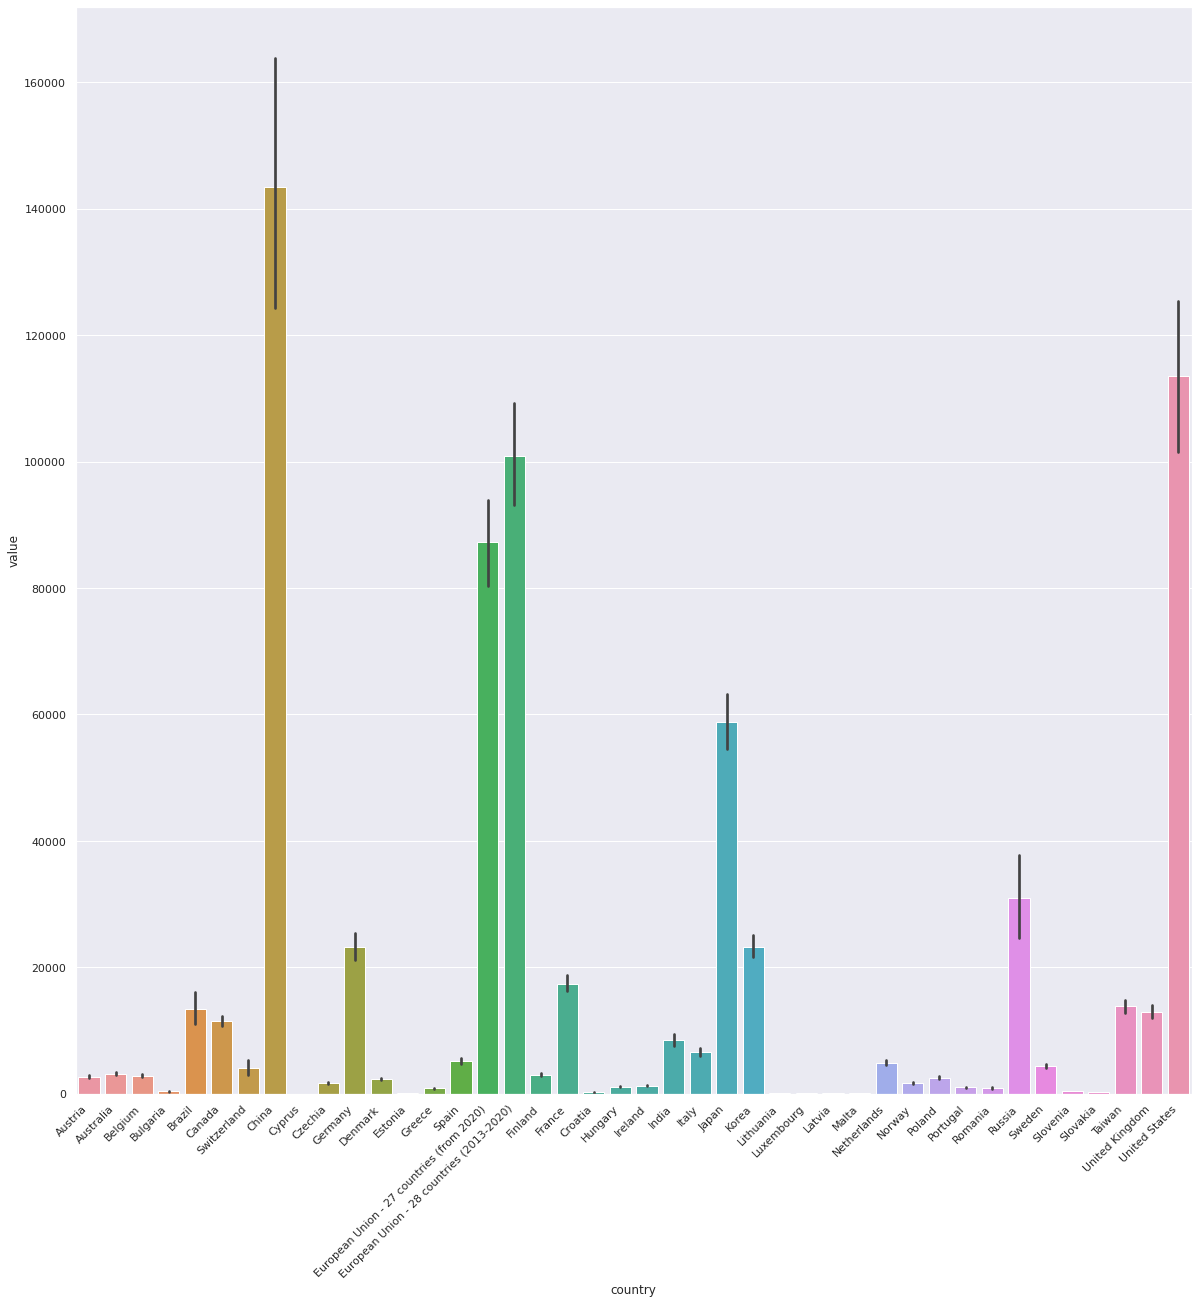

In [ ]:
# barplot for the categorical feature country and numerical value
fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.barplot(ax=ax, x='country', y='value', data=df_plot)
plt.show()

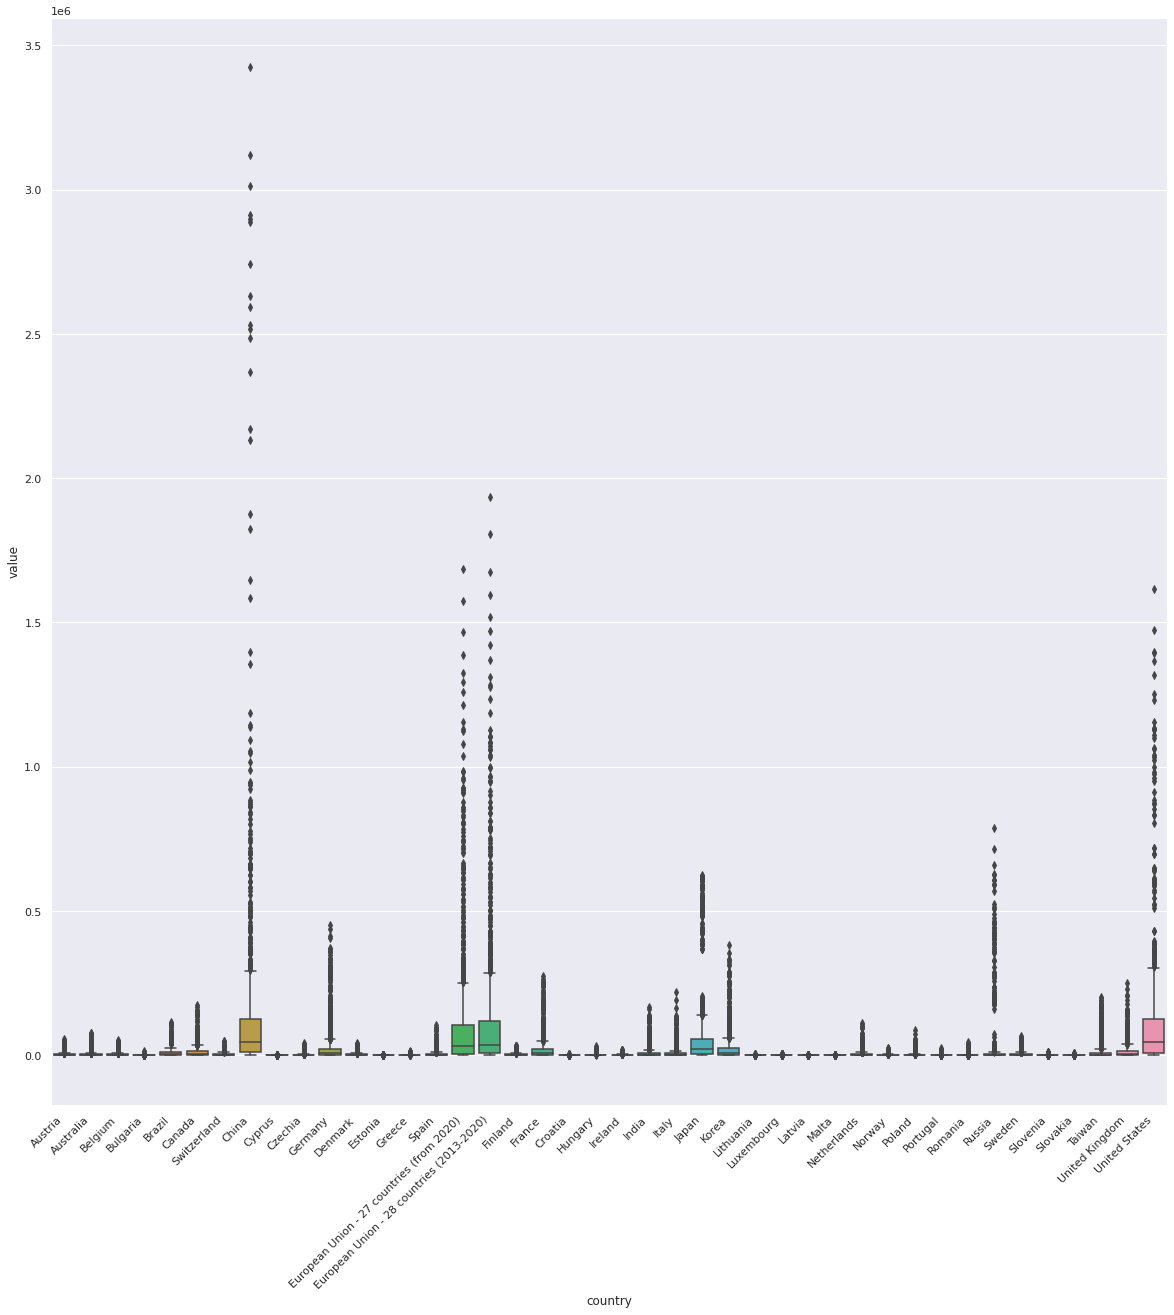

In [ ]:
# boxplot for the categorical feature country and numerical value
fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.boxplot(ax=ax, x='country', y='value', data=df_plot)
plt.show()

In this plot there are some interesting facts, for example that **China** is the country that has the highest FullTimeEquivalent so in this country a man in average works more than other countries. Another interesting fact is in the boxplot because it draws some outliers so those must be handled.

##1.2 Preprocessing

We know that in clustering tasks we deserve to use numerical data, data should have no noises or for example we could remove some useless features. So we must clean our data before we start our clustering algorithm.

In [ ]:
# Data Cleaning
# remove duplicates if there are
df_c_d = df_c.drop_duplicates()
if (df_c_d.count()) == (df_c.count()):
  print("1) No Duplicates")
else:
  print("1) There are Duplicates")

# remove unnecessary features, in this task all features are unnecessary expect for country and value
df_clustering = df_c.select('country', 'value') 

# transform categorical data country and year with StringIndexer
encoder = StringIndexer(inputCol='country', outputCol='countryIDX')
df_clustering = encoder.fit(df_clustering).transform(df_clustering)
print('2) Not Encoded and Encoded features:')
print(df_clustering.groupBy('country', 'countryIDX').count().show(42, False))

# remove year and country features
df_clustering = df_clustering.select('countryIDX', 'value')
print('3) Dataset new shape')
print(df_clustering.show(10, False))

1) No Duplicates
2) Not Encoded and Encoded features:
+-----------------------------------------+----------+-----+
|country                                  |countryIDX|count|
+-----------------------------------------+----------+-----+
|India                                    |36.0      |1498 |
|Korea                                    |21.0      |2100 |
|Canada                                   |1.0       |2574 |
|Bulgaria                                 |15.0      |2222 |
|Italy                                    |7.0       |2306 |
|Malta                                    |32.0      |1936 |
|Slovenia                                 |26.0      |2082 |
|Greece                                   |27.0      |1946 |
|United Kingdom                           |9.0       |2306 |
|United States                            |38.0      |1161 |
|Belgium                                  |22.0      |2090 |
|Norway                                   |34.0      |1792 |
|Slovakia                      

Clustering algorithm are very sensitive to noisy data and outliers, so let see the descriptions of the summary statistics.

In [ ]:
# look at descriptive statistics
df_clustering.describe().show()

+-------+------------------+-----------------+
|summary|        countryIDX|            value|
+-------+------------------+-----------------+
|  count|             83203|            83203|
|   mean|17.979303630878693|14740.70115260267|
| stddev|11.267968783776267| 74263.9200533166|
|    min|               0.0|              0.0|
|    max|              41.0|        3424780.0|
+-------+------------------+-----------------+



A nice thing to do is to find the outliers with some function and apply a technique. In this case I used *Winsorization* technique to first of all handling outliers and it works in this way: you choose a certain percentile value (e.g., 90) and for each feature $f_i$ you replace any value $x_i$ which falls either below the 5-th percentile or above the 95-th percentile with the 5-th and the 95-th percentile, respectively. First of all see what are the outliers.

In [ ]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = df.columns

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)

        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    for column in selected_columns:
      df.groupBy(column).count().show() 

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [ ]:
df_outliers = find_outliers(df_clustering)

+---------------------+-----+
|is_outlier_countryIDX|count|
+---------------------+-----+
|                    0|83203|
+---------------------+-----+

+----------------+-----+
|is_outlier_value|count|
+----------------+-----+
|               1|13203|
|               0|70000|
+----------------+-----+



So outliers are only on the value feature, so now Winsorization can be performed.

In [ ]:
#" Winsorizarion 
# store in a dictionary the quantiles
d = {}

# Fill in the entries one by one
for column in df_clustering.columns:
      d[column] = df_clustering.approxQuantile(column,[0.25,0.75],0.25)
      print(column+" done")

countryIDX done
value done


Here there is the winsorization technique and I decide to use log transform and log(x + 1) when x is 0.

In [ ]:
# looping through the columns, doing log(x+1) transformations because of the log(0) error
for column in df_clustering.columns:
    df_new = df_clustering.withColumn(column, \
    f.log(f.when(df_clustering[column] < d[column][0],d[column][0])\
    .when(df_clustering[column] > d[column][1], d[column][1])\
    .otherwise(df_clustering[column] ) + 1).alias(column))
    print(column+" done")

countryIDX done
value done


Scaling of the features with the *StandardScaler*, I decide to set std and mean at True to standardize all the features to 0-mean and 1-unit of standard deviation.

In [ ]:
# VectorAssembler and Scaler on all columns of the dataset
assemblers = [VectorAssembler(inputCols=[c], outputCol=c + "_vec") for c in df_new.columns]
scalers = [StandardScaler(inputCol=c + "_vec", outputCol=c + "_scaled", withStd=True, withMean=True) for c in df_new.columns]

# Transformed data
scaled_data = Pipeline(stages=assemblers + scalers).fit(df_new).transform(df_new)

# UDF for converting column type from vector to double type
unlist = udf(lambda x: float(list(x)[0]), DoubleType())
features = ['value_scaled', 'countryIDX_scaled']
for i in features:
  scaled_data = scaled_data.withColumn(i + '_new', unlist(i))

# dataframe scaled
df_cscaled = scaled_data.select('value_scaled_new', 'countryIDX_scaled_new')

In [ ]:
# look at descriptive statistics
df_cscaled.describe().show()

+-------+--------------------+---------------------+
|summary|    value_scaled_new|countryIDX_scaled_new|
+-------+--------------------+---------------------+
|  count|               83203|                83203|
|   mean|2.574258166983457...| -8.64917951008773...|
| stddev|  1.0000000000000029|    1.000000000000002|
|    min| -1.7511929139492617|  -1.5956117713749383|
|    max|   2.716128053658273|     2.04302095709271|
+-------+--------------------+---------------------+



In [ ]:
# combine features in a VectorAssembler
assembler = VectorAssembler(inputCols = df_cscaled.columns, outputCol = 'features')
df_task = assembler.transform(df_cscaled)
df_task = df_task.select('features')
df_task.cache()

DataFrame[features: vector]

In [ ]:
# check if there are 0 length vectors
@udf("long")
def num_nonzeros(v):
    return v.numNonzeros()

In [ ]:
print("Total n. of zero-length vectors: {:d}".
      format(df_task.where(num_nonzeros("features") == 0).count()))

Total n. of zero-length vectors: 0


In [ ]:
print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 360 objects


Now the Clustering algorithm can be performed

##**1.3 Model**
Model functions.

In [ ]:
def k_means(dataset, 
            n_clusters, 
            distance_measure="euclidean", 
            max_iter=20, 
            features_col="features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):
  
  from pyspark.ml.clustering import KMeans
  from pyspark.ml.feature import Normalizer

  print("""Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  """.format(n_clusters, max_iter, distance_measure, random_seed))

  if distance_measure == "cosine":
      # Normalize inputs to unit-length vectors
      dataset = Normalizer(inputCol=features_col, outputCol=features_col+"_norm", p=1).transform(dataset)
      features_col = features_col+"_norm"
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=0.000001, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset)

  return model, clusters_df

In [ ]:
def evaluate_method(clusters, 
                     metric_name="silhouette", 
                     distance_measure="squaredEuclidean", # cosine
                     prediction_col="cluster"
                     ):
  
  from pyspark.ml.evaluation import ClusteringEvaluator
  
  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure, 
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In [ ]:
def do_clustering():
    clustering_results = {}
    for k in range(2, MAX_K_CLUSTERS + 1):
        print("Running K-means using K = {:d}".format(k))
        model, clusters_df = k_means(df_task, k, max_iter=50, distance_measure="cosine")
        silhouette_k = evaluate_method(clusters_df, distance_measure="cosine") 
        wssd_k = model.summary.trainingCost
        print("Silhouette coefficient computed with cosine distance: {:.3f}".format(silhouette_k))
        print("Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(wssd_k))
        print("--------------------------------------------------------------------------------------")
        clustering_results[k] = (silhouette_k, wssd_k)
        # Free up memory space at the end of each iteration
        del model
        del clusters_df
        gc.collect()
    return clustering_results

Results of the clustering algorithm using the *Silhouette Coefficient*.

In [ ]:
clustering_results = do_clustering()

Running K-means using K = 2
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 2
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.642
Within-cluster Sum of Squared Distances (using cosine distance): 24024.219
--------------------------------------------------------------------------------------
Running K-means using K = 3
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 3
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  
Silhouette coefficient computed with cosine distance: 0.675
Within-cluster Sum of Squared Distances (using cosine distance): 12704.899
--------------------------------------------------------------------------------------
Running K-means using K = 4
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 4
  - max_iter (max 

In [ ]:
def plot_clustering_results(clustering_results):
    # load the dictionary into pandas
    df = pd.DataFrame.from_dict(clustering_results, orient='index').reset_index()
    df.columns = ['K','Silhouette', 'WSSD']
    # Create a 1x1 figure
    fig, ax = plt.subplots(1,1, figsize=(16,8))

    _ = sns.pointplot(data=df, x="K", y="WSSD", ax=ax, color="orangered")
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")

Elbow method for choose the correct K.

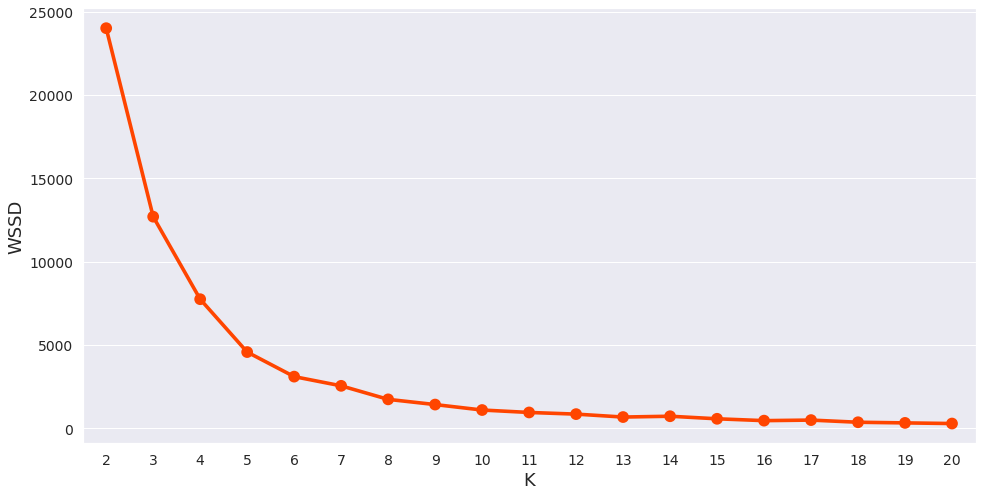

In [ ]:
plot_clustering_results(clustering_results)

In this Elbow graph 7 in my opinion is the best k value to choose.

In [ ]:
K=7  # Best value of K (whatever this is!)
print("Running K-means using K = {:d}".format(K))
model, clusters_df = k_means(df_task, K, max_iter=50, distance_measure="cosine")
clusters_df.cache()

Running K-means using K = 7
Training K-means clustering using the following parameters: 
  - K (n. of clusters) = 7
  - max_iter (max n. of iterations) = 50
  - distance measure = cosine
  - random seed = 42
  


DataFrame[features: vector, features_norm: vector, cluster: int]

Inspect clusters.

In [ ]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|13328|
|      1|13226|
|      2|11996|
|      3|17876|
|      4| 7636|
|      5|10786|
|      6| 8355|
+-------+-----+



In [ ]:
# Get unique valu+es in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results
for x_id, x in enumerate(cluster_list):
  print("Showing the first 10 records of cluster ID #{:d}".format(x_id))
  x.select(["cluster", "features"]).show(10, truncate=False)

Cluster IDs: [0, 1, 2, 3, 4, 5, 6]
Showing the first 10 records of cluster ID #0
+-------+----------------------------------------+
|cluster|features                                |
+-------+----------------------------------------+
|0      |[1.0759785882196795,-1.5956117713749383]|
|0      |[1.0646597785324858,-1.5956117713749383]|
|0      |[1.052068979101606,-1.5956117713749383] |
|0      |[1.0451820283047453,-1.5956117713749383]|
|0      |[1.056974985113687,-1.5956117713749383] |
|0      |[1.0670434470146493,-1.5956117713749383]|
|0      |[1.0825556211092364,-1.5956117713749383]|
|0      |[1.1244379489810516,-1.5956117713749383]|
|0      |[1.143232310389053,-1.5956117713749383] |
|0      |[1.1457514984069612,-1.5956117713749383]|
+-------+----------------------------------------+
only showing top 10 rows

Showing the first 10 records of cluster ID #1
+-------+----------------------------------------+
|cluster|features                                |
+-------+----------------------

In [ ]:
# adjust features with numpy arrays for the clustering plot
m = np.array(clusters_df.select('features').collect())
m = m[0:, 0]
z = np.array(clusters_df.select('cluster').collect())
z = z[0:, 0]

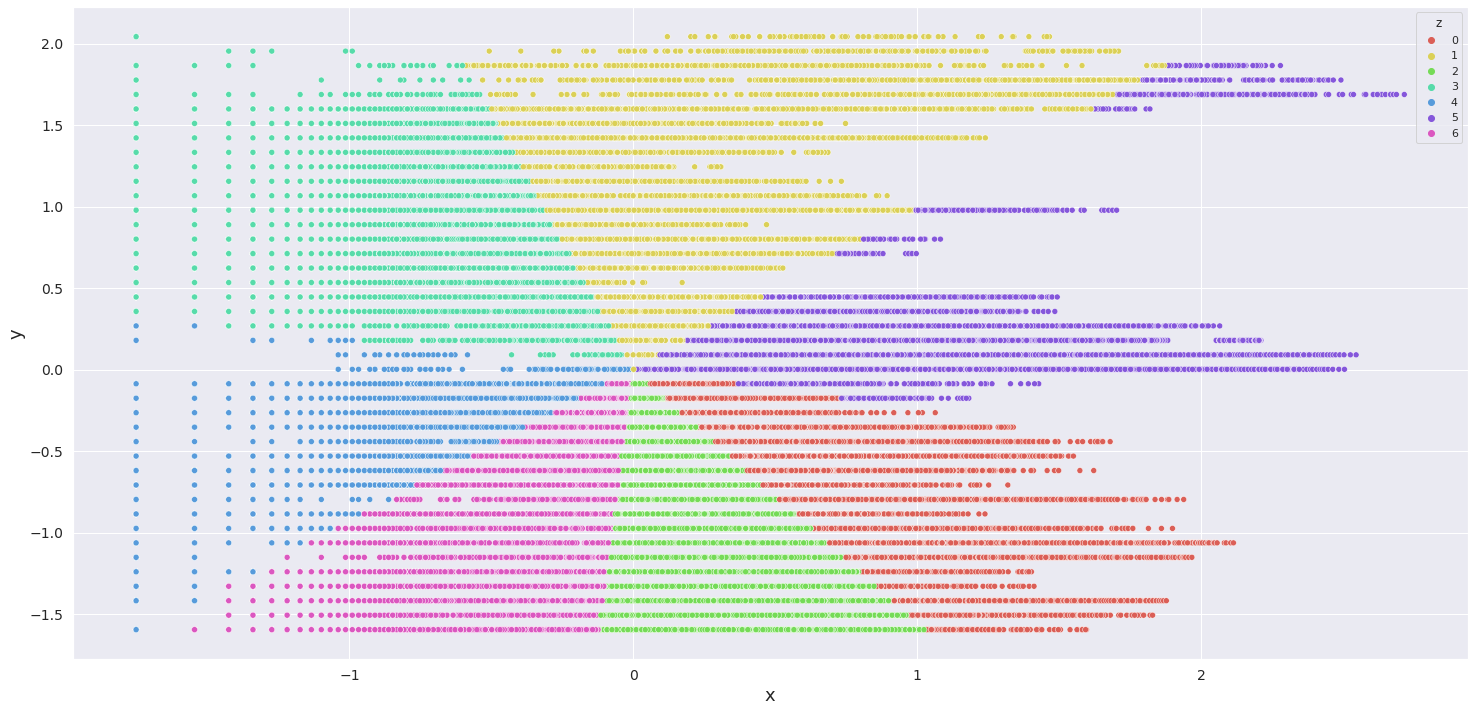

In [ ]:
# construct pandas dataframe
df_plot = pd.DataFrame(m, columns=['x', 'y'])
df_plot['z'] = z

# plot
plt.figure(figsize=(25,12))
sns.scatterplot(x='x',y='y',hue='z',palette=sns.color_palette("hls",7),data=df_plot,
               legend="full")
plt.show()

# **2 Regression**
Now it's time for the regression task to predict the costs of the countries and their ICT industries. The models that I want to perform are:
- **LinearRegression**.
- **GeneralizedLinearRegression** are specifications of linear models where the response variable Yi follows some distribution from the exponential family of distributions and I would like to try with Gaussian and Tweedie.
- **DecisionTreeRegression**.
- **RandomForestRegression**.
- **GradiendBoostedTreeRegression**.
- **LassoRegression**.
- **RidgeRegression**.
- **FMRegression** is able to estimate interactions between features even in problems with huge sparsity. 


##**2.1 Data Exploration**
Let's do some data exploration also on the dataset of the regression task.

In [ ]:
# dataframe to pandas
df_pandas = df_r.toPandas()

variablecode vs value

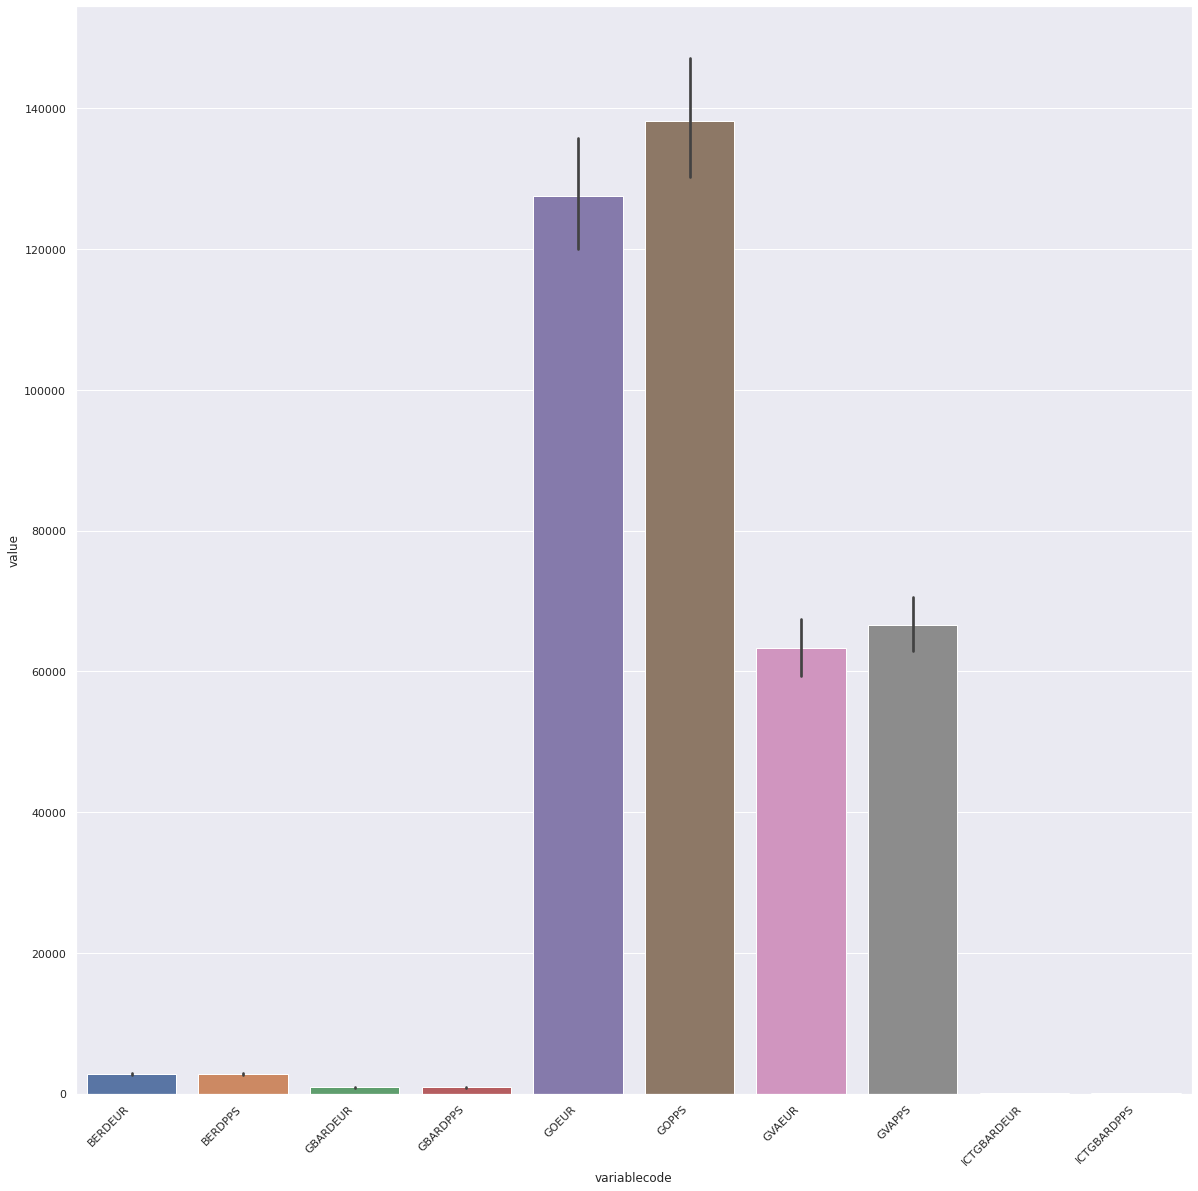

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.barplot(data=df_pandas, x='variablecode', y='value', ax=ax)
plt.show()

country vs value


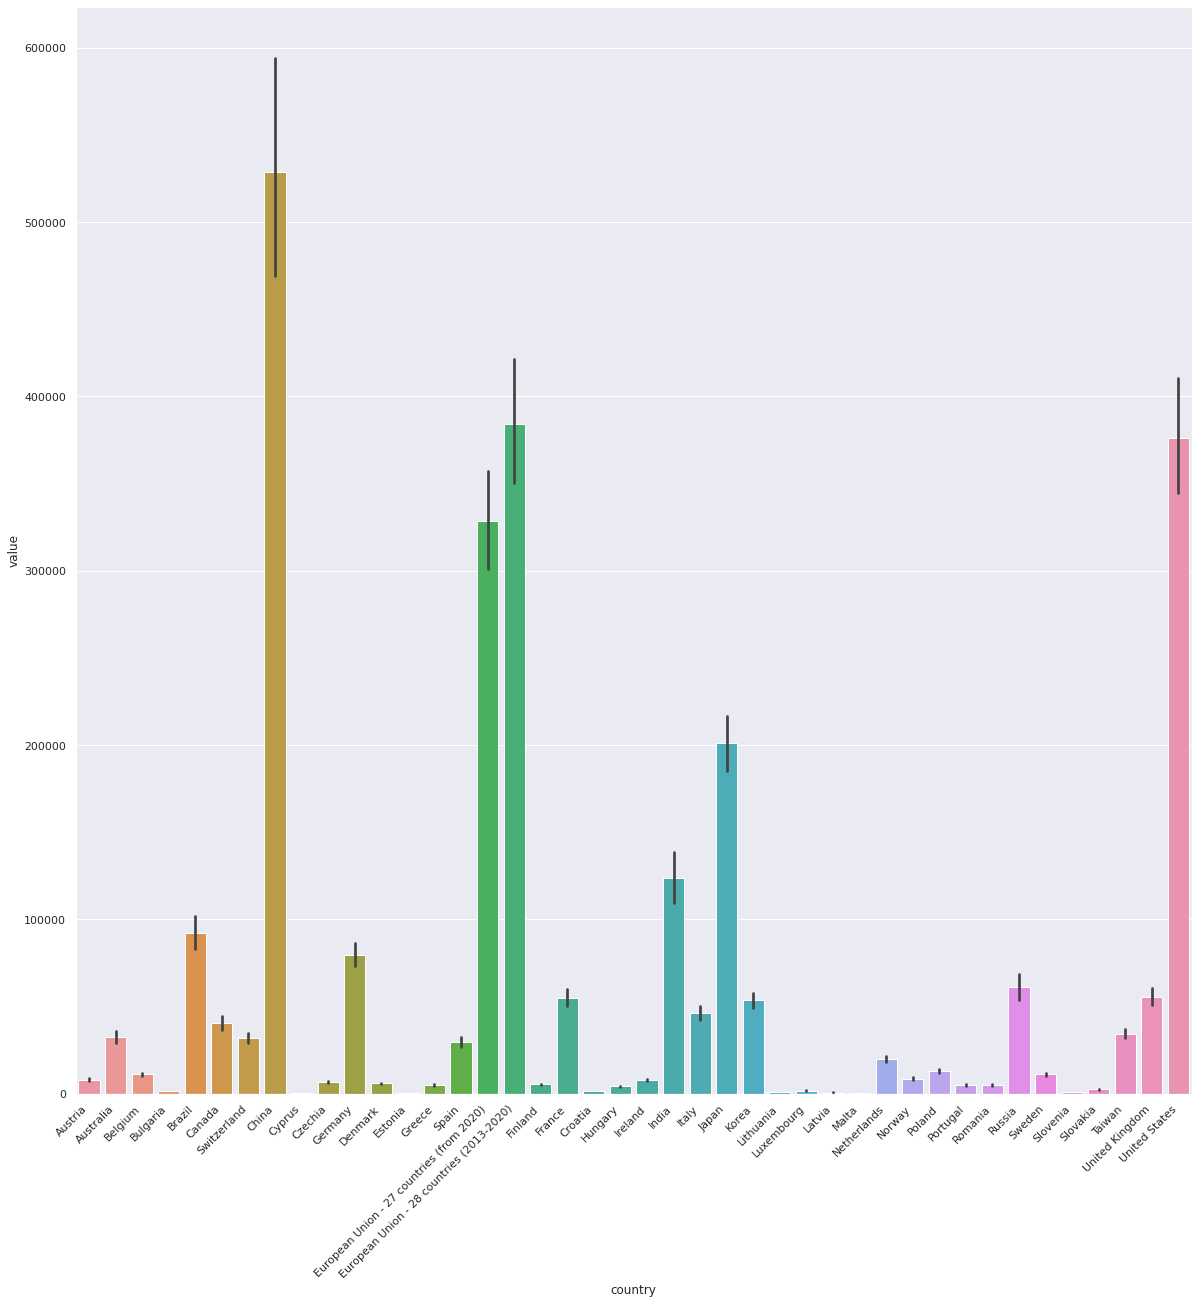

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.barplot(data=df_pandas, x='country', y='value', ax=ax)
plt.show()

definition vs value

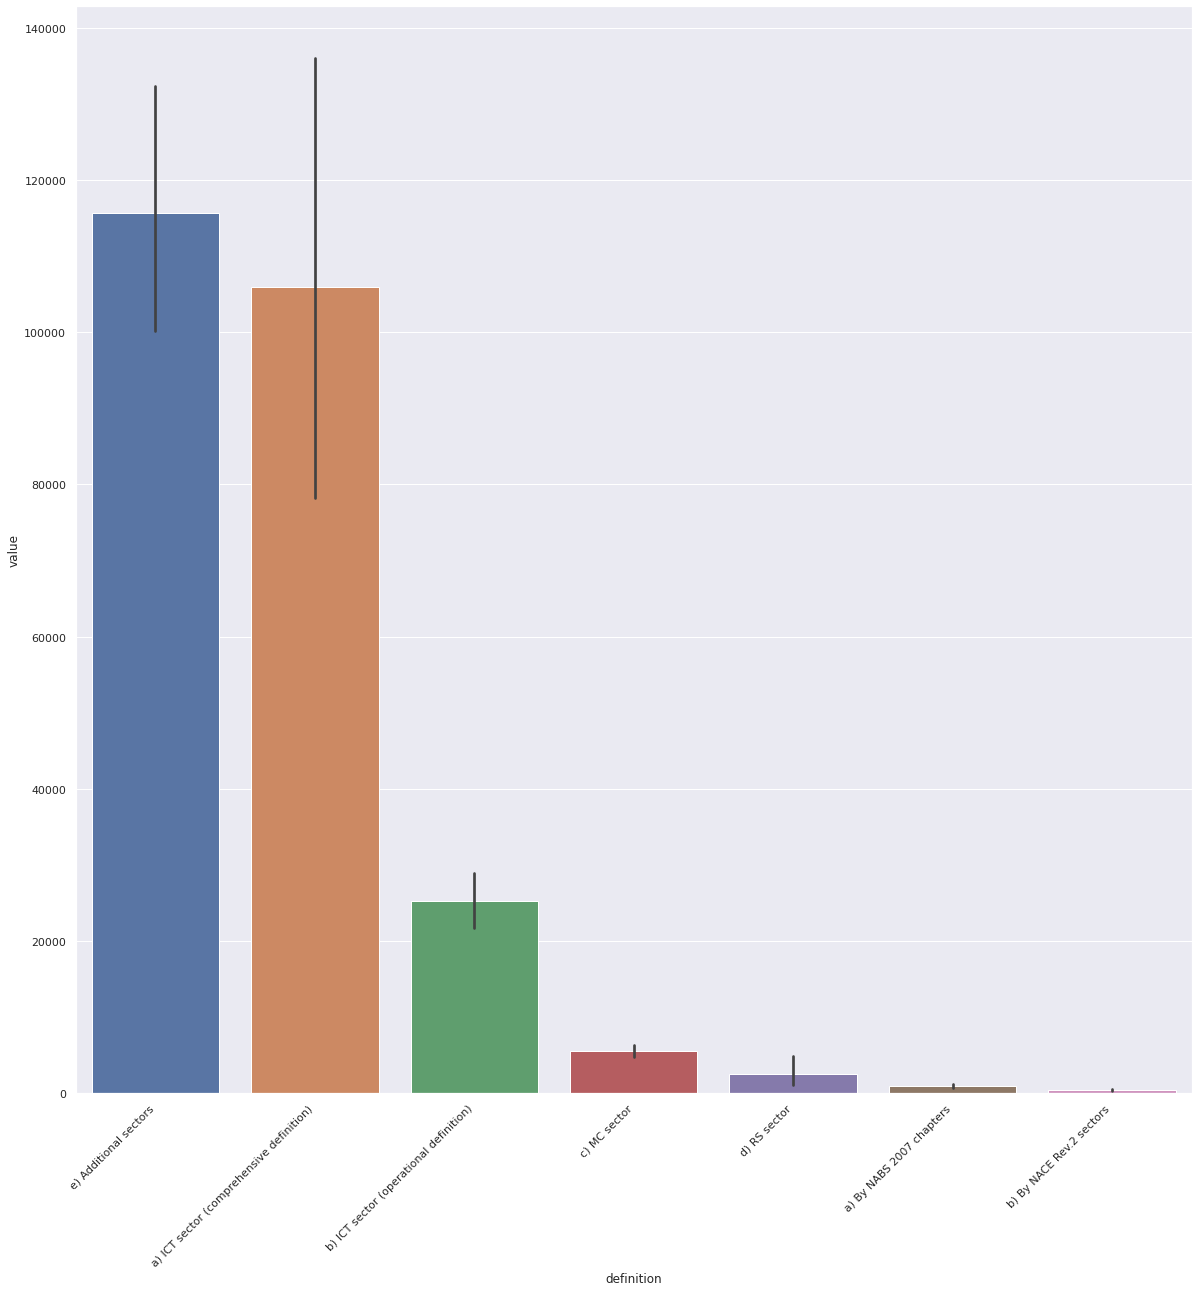

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.barplot(data=df_pandas, x='definition', y='value', ax=ax)
plt.show()

year vs value

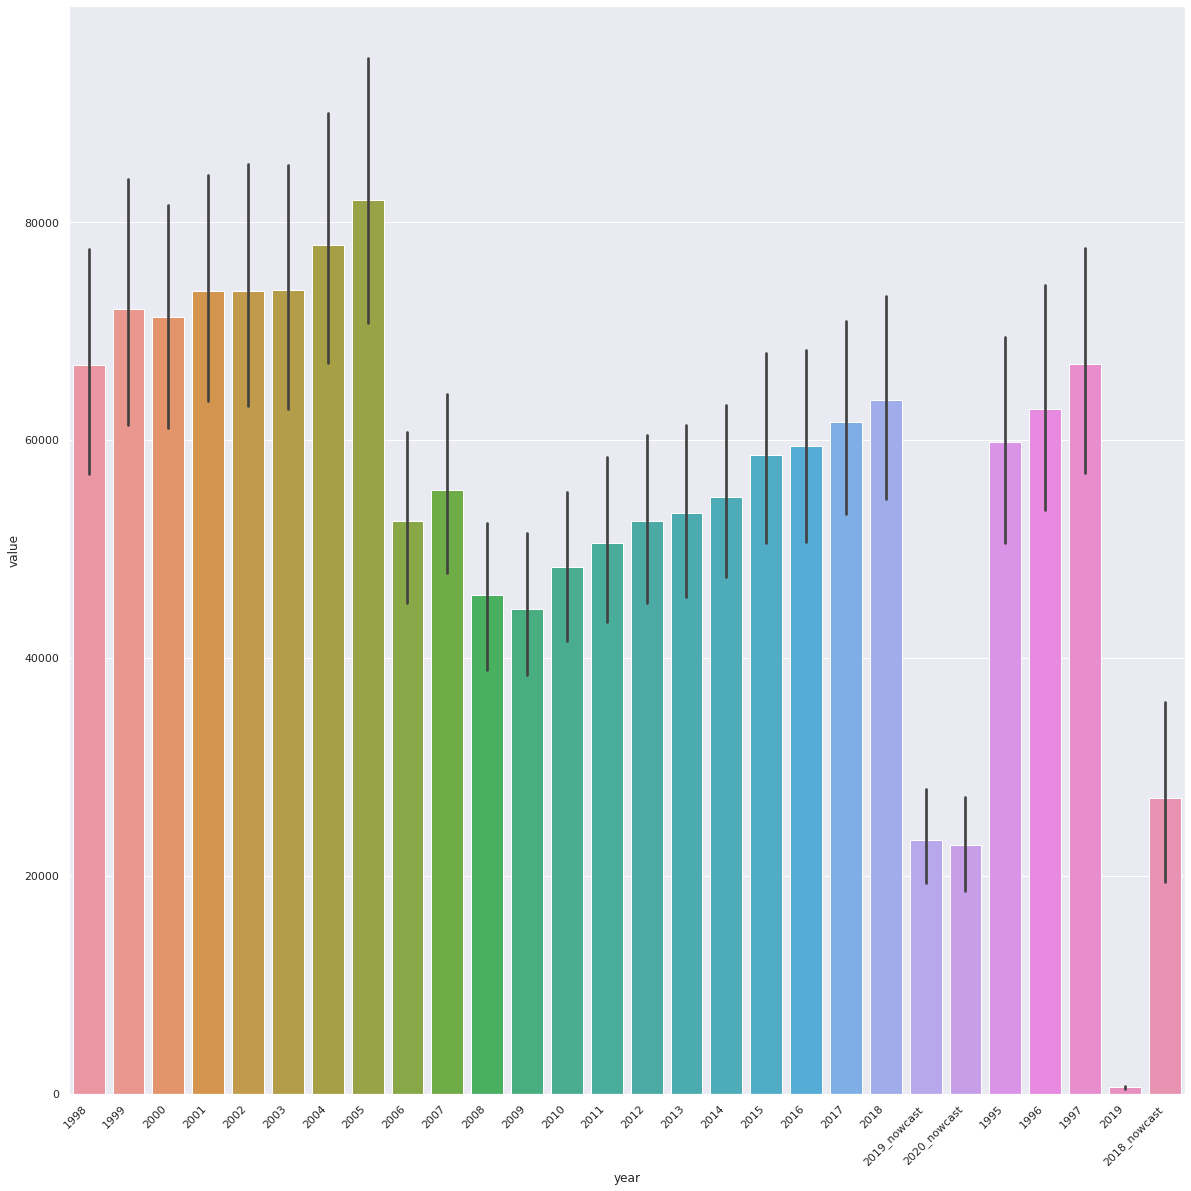

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(rotation=45, ha='right')
sns.set(font_scale=1)
sns.barplot(data=df_pandas, x='year', y='value', ax=ax)
plt.show()

## **2.2 Preprocessing**
Let's take a look to the data, viewing summary statistics and some plots. A good thing also to do is to look if the data label has some outliers and I want to use a log transformation, because the label has a weird distribution with values in some area and other values in another.

In [ ]:
df_r.describe().show()

+-------+------------+--------------------+--------------------+-----------+-------------+--------------+------------------+--------------------+-----------------+--------------------+------------------+------------------+
|summary|variablecode|                unit|        dataset_type|countrycode|      country|classification|classificationcode|          definition|       sectorcode|         description|              year|             value|
+-------+------------+--------------------+--------------------+-----------+-------------+--------------+------------------+--------------------+-----------------+--------------------+------------------+------------------+
|  count|      419772|              419772|              419772|     419772|       419772|        419772|            419772|              419772|           419772|              419772|            419772|            419772|
|   mean|        null|                null|                null|       null|         null|          null|118

Need to encode the categorical feature to plot them with pandas dataframe, first of all to look the data I decide to use StringIndexer.

In [15]:
# StringIndexer except for value
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_r) for column in list(set(df_r.columns)-set(['value'])) ]

# Pipeline to perform encoding
pipeline = Pipeline(stages=indexers)
df_ri = pipeline.fit(df_r).transform(df_r)

# drop the columns not indexed
for i in list(set(df_ri.columns) - set(['value'])):
  if not(i.endswith('_index')):
    df_ri = df_ri.drop(i)
df_ri.show()

+-----------+-------------+----------+-----------------+------------------+------------------------+----------------+----------+-----------------+----------------+------------------+--------------------+
|      value|country_index|unit_index|countrycode_index|variablecode_index|classificationcode_index|definition_index|year_index|description_index|sectorcode_index|dataset_type_index|classification_index|
+-----------+-------------+----------+-----------------+------------------+------------------------+----------------+----------+-----------------+----------------+------------------+--------------------+
|   1641.396|         15.0|       0.0|             15.0|               4.0|                    17.0|             1.0|      20.0|             18.0|            17.0|               0.0|                 0.0|
|   1869.113|         15.0|       0.0|             15.0|               4.0|                    17.0|             1.0|      19.0|             18.0|            17.0|               0.0|  

In [16]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = df.columns

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)

        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    for column in selected_columns:
      df.groupBy(column).count().show() 

    return df

In [ ]:
df_ro = find_outliers(df_ri)
df_ro = df_ro.drop(*[column for column in df_ro.columns if column.startswith('is_outlier')])

+----------------+------+
|is_outlier_value| count|
+----------------+------+
|               1| 73701|
|               0|346071|
+----------------+------+

+------------------------+------+
|is_outlier_country_index| count|
+------------------------+------+
|                       0|419772|
+------------------------+------+



Distribution of the label.

**Note:** I use bins for plot the distribution because if I set discrete to True google colab crashes for RAM issues. And the plot is not really correct (I don't know why the negative values are not in the plot, maybe because they are in the area where is the 0) because the values are widely ranged between -2000 and 40.000.000.

Values of the label

312978   -2.291530e+03
373952   -2.017663e+03
278694   -1.105417e+03
278718   -1.105417e+03
312980   -9.937021e+02
              ...     
204329    3.717469e+07
204330    3.802495e+07
204331    3.819036e+07
204332    4.012330e+07
204333    4.206867e+07
Name: value, Length: 419772, dtype: float64
-------------------

Sort the value counts

0.000000e+00    14188
1.000000e+00       26
1.600000e-02       24
2.900000e-02       22
2.200000e+00       20
                ...  
6.216500e+01        1
6.216370e+01        1
6.215495e+01        1
6.215455e+01        1
4.206867e+07        1
Name: value, Length: 346338, dtype: int64
-------------------

Distribution


(-2291.53007162255, 42068670.6005323)

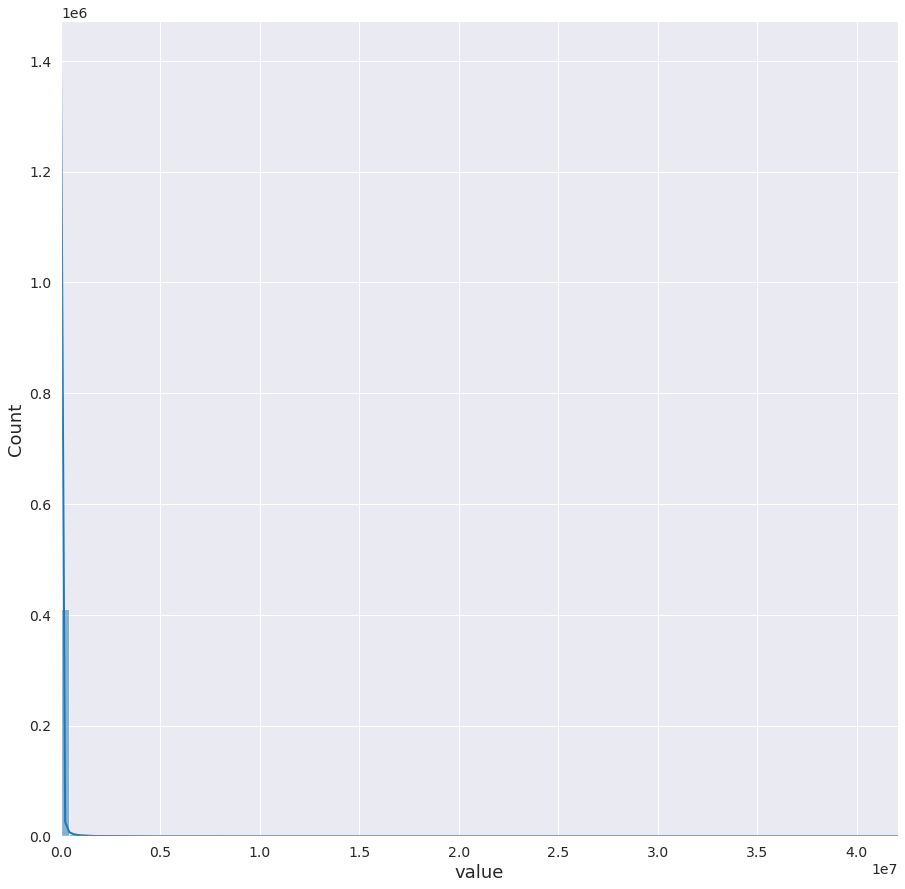

In [24]:
df_pd = df_ro.toPandas()
print('Values of the label\n')
print(df_pd['value'].sort_values())
print('-------------------\n')
print('Sort the value counts\n')
print(df_pd['value'].sort_values().value_counts())
print('-------------------\n')
print('Distribution')
fig, ax = plt.subplots(figsize=(15,15))   
sns.histplot(df_pd, x='value', ax=ax, bins=100, kde=True)
ax.set_xlim(df_pd['value'].min(), df_pd['value'].max())

The distribution is skewed and has a weird distribution and also the label has some outliers so it should be normalized in some way, a good idea is to perform a log transformation, but there is the problem in which there are values <= 0 so I decide to perform this kind of function:
- ` sign(log(abs(x) + 1))`



In [ ]:
df_scaled = df_ro.withColumn("logvalue", f.signum(col("value"))*(log(abs(col("value")) + 1)))
df_scaled.show()

+-----------+----------------+------------------------+-----------------+------------------+--------------------+----------+----------------+----------+------------------+-----------------+-------------+-----------------+
|      value|definition_index|classificationcode_index|description_index|variablecode_index|classification_index|unit_index|sectorcode_index|year_index|dataset_type_index|countrycode_index|country_index|         logvalue|
+-----------+----------------+------------------------+-----------------+------------------+--------------------+----------+----------------+----------+------------------+-----------------+-------------+-----------------+
|   1641.396|             1.0|                    17.0|             18.0|               4.0|                 0.0|       0.0|            17.0|      20.0|               0.0|             15.0|         15.0|7.403911430241456|
|   1869.113|             1.0|                    17.0|             18.0|               4.0|                 0.0

Now replot the distribution.

(-7.737411321437194, 17.554813879135974)

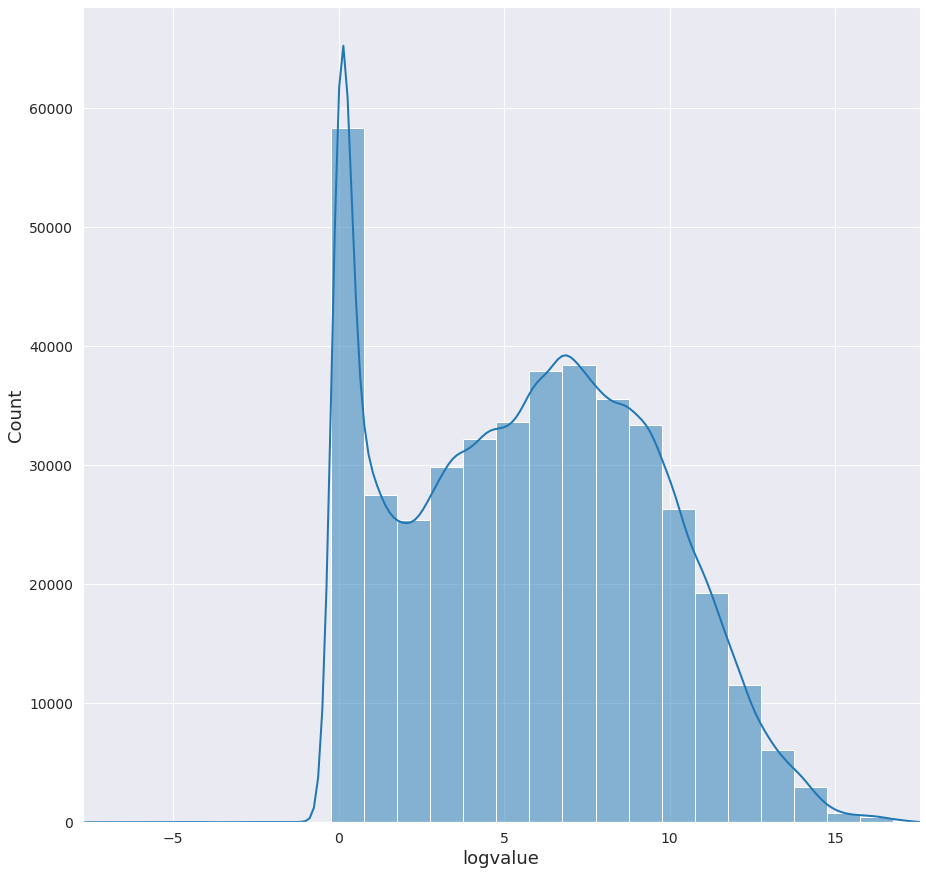

In [ ]:
df_pd = df_scaled.toPandas()
fig, ax = plt.subplots(figsize=(15,15))   
sns.histplot(df_pd, x='logvalue', ax=ax, discrete=True, kde=True)
ax.set_xlim(df_pd['logvalue'].min(), df_pd['logvalue'].max())

A nice plot and measure that can be used to choose the right features is the *Correlation Matrix* to see their correlations. 

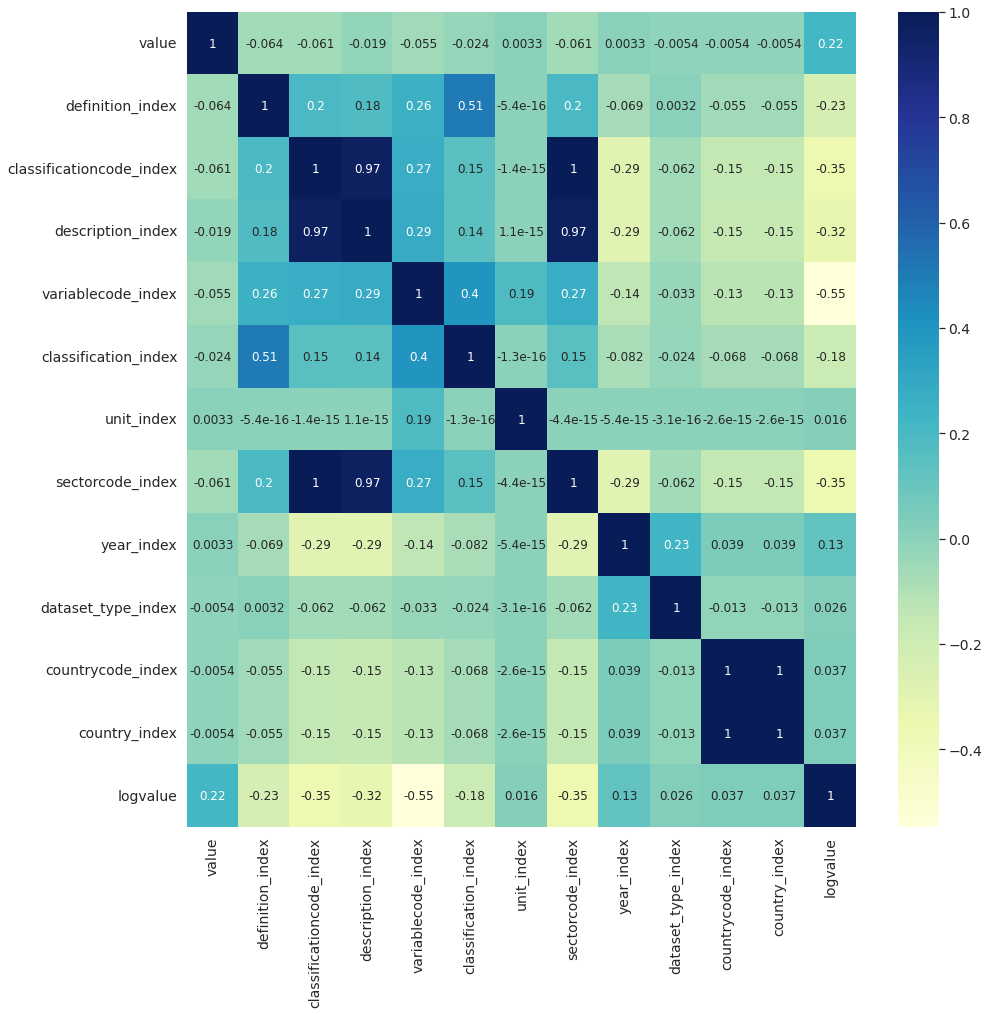

In [ ]:
# heatmap plot  
fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(df_pd.corr(), cmap="YlGnBu", annot=True, ax=ax)

So we have collinearity in <code>country_index</code> and <code>countrycode_index</code>, <code>classificationcode_index</code> and <code>sectorcode_index</code> and <code>description_index</code>. A good idea is to calculate the *VIF* of these features and if this value is greater than 5, the feature with this value can be removed.

In [ ]:
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = df_pd[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [ ]:
# features to consider removing
considered_features = ['country_index', 'countrycode_index', 'classificationcode_index', 'sectorcode_index', 'description_index']


# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,country_index,inf
1,countrycode_index,inf
3,sectorcode_index,1.391818e+04
2,classificationcode_index,1.390302e+04
4,description_index,1.625586e+01


Try to remove <code>country_index</code>.

In [ ]:
# compute vif values after removing a feature
considered_features.remove('country_index')
compute_vif(considered_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Variable,VIF
0,countrycode_index,1.024941
1,classificationcode_index,13903.016480
2,sectorcode_index,13918.180234
3,description_index,16.255864


Now remove <code>sectorcode_index</code>.

In [ ]:
# compute vif values after removing a feature
considered_features.remove('sectorcode_index')
compute_vif(considered_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Variable,VIF
0,countrycode_index,1.024941
1,classificationcode_index,16.236556
2,description_index,16.238193


Now remove <code>description_index</code>.

In [ ]:
# compute vif values after removing a feature
considered_features.remove('description_index')
compute_vif(considered_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Variable,VIF
0,countrycode_index,1.024488
1,classificationcode_index,1.024488


Now the VIF is below 5 so in the dataframe features that can be removed are:
- <code>country_index</code>.
- <code>sectorcode_index</code>.
- <code>description_index</code>.

In [ ]:
DROP_FEATURES = ['country', 'sectorcode', 'description']

# drop features
for i in DROP_FEATURES:

  # Labeled dataset and Log transformed dataset
  df_scaled = df_scaled.drop(i + '_index')

df_r.show(5, False)
df_scaled.show(5, False)

+------------+-------------------------+--------------------+-----------+--------------+------------------+---------------------+----+-----------+
|variablecode|unit                     |dataset_type        |countrycode|classification|classificationcode|definition           |year|value      |
+------------+-------------------------+--------------------+-----------+--------------+------------------+---------------------+----+-----------+
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|1998|1641.396   |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|1999|1869.113   |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|2000|2041.91565 |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Addition

##**2.3 Learning Pipeline and a try with OLS**
Now it's time to split the dataset in test and train set, I decide to split:
- 80% Train.
- 20% Test.

In [ ]:
# remove value features because in this case we have logvalue
df_scaled = df_scaled.drop('value')
print(df_scaled.show())

# Randomly split labeled and log transformed dataset 'df_scaled' into 80÷20 for training and test, respectively
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

+----------------+------------------------+------------------+--------------------+----------+----------+------------------+-----------------+-----------------+
|definition_index|classificationcode_index|variablecode_index|classification_index|unit_index|year_index|dataset_type_index|countrycode_index|         logvalue|
+----------------+------------------------+------------------+--------------------+----------+----------+------------------+-----------------+-----------------+
|             1.0|                    17.0|               4.0|                 0.0|       0.0|      20.0|               0.0|             15.0|7.403911430241456|
|             1.0|                    17.0|               4.0|                 0.0|       0.0|      19.0|               0.0|             15.0|7.533754135830432|
|             1.0|                    17.0|               4.0|                 0.0|       0.0|      18.0|               0.0|             15.0|7.622133306642712|
|             1.0|                

Let's try to perform a simple linear regression to look how the model works with default data on the training set of the dataset labeled.

In [ ]:
# assemble in a vector the features
feature_vector = list(set(train_df.columns) - set(['logvalue']))
assembler = VectorAssembler(inputCols=feature_vector, outputCol='features')
train_d = assembler.transform(train_df)
train = train_d.select(['features', 'logvalue'])
train.show(truncate=False)

# First of all, let's just setup a very basic OLS linear regressor (i.e., univariate with no regularizatio term)
lr = LinearRegression(featuresCol='features', labelCol='logvalue')

# Train the actual model on our training set `simple_train_df`
lr_model = lr.fit(train)

+--------------+------------------+
|features      |logvalue          |
+--------------+------------------+
|(8,[],[])     |9.820627546668975 |
|(8,[0],[1.0]) |10.179868507232754|
|(8,[0],[3.0]) |10.121015365064702|
|(8,[0],[4.0]) |7.70796153183549  |
|(8,[0],[5.0]) |7.842514415139335 |
|(8,[0],[7.0]) |6.664281461194676 |
|(8,[0],[9.0]) |12.086191660716633|
|(8,[0],[10.0])|11.828981414616099|
|(8,[0],[11.0])|12.620602588563296|
|(8,[0],[12.0])|8.726383852312214 |
|(8,[0],[14.0])|7.906141993732197 |
|(8,[0],[15.0])|7.958716754174241 |
|(8,[0],[16.0])|6.192362489474872 |
|(8,[0],[17.0])|7.028024111373082 |
|(8,[0],[18.0])|7.957842368374517 |
|(8,[0],[20.0])|5.83305481036034  |
|(8,[0],[21.0])|5.756058619221572 |
|(8,[0],[22.0])|5.8888779583328805|
|(8,[0],[24.0])|9.621522440413576 |
|(8,[0],[25.0])|7.753280139962965 |
+--------------+------------------+
only showing top 20 rows



Evaluation.

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.989
R2: 0.372
Adjusted R2: 0.372
***** Training Set *****


Let's try to one-hot-encode the categorical feature.

In [ ]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def to_numerical(df, features, target_variable):

    """
    Args:
        - df: the input dataframe
        - features: the list of column names in `df` corresponding to the features
        - target_variable: the column name in `df` corresponding to the target variable

    Return:
        - transformer: the pipeline of transformation fit to `df` (for future usage)
        - df_transformed: the dataframe transformed according to the pipeline
    """

    # 0. Log transform the target variable
    df = df.withColumn('log' + target_variable, f.signum(col(target_variable))*(log(abs(col(target_variable)) + 1)))

    # 1. Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 2. Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")
    
    # 3. Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")

    # 4. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=indexers + [encoder] + [assembler])

    # 5. Transform the input dataframe accordingly
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    # 6. Optionally, change the name of the target variable to `label` (if that is different), as PySpark implicitly assumes this is the name of the column to predict
    if target_variable != "label":
        df_transformed = df_transformed.withColumnRenamed('log' + target_variable, "label")

    # 7. Eventually, return both the transformed dataframe and the transformer object for future transformations
    return transformer, df_transformed 

Split original dataset.

In [ ]:
# Randomly split original dataset 'df_r' into 80÷20 for training and test, respectively
train_df, test_df = df_r.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [ ]:
# Transform the training set and get back both the transformer and the new dataset
FEATURES = list(set(train_df.columns) - set(['value']))
TARGET_VARIABLE = 'value'
oh_transformer, oh_train_df = to_numerical(train_df, FEATURES, TARGET_VARIABLE)
oh_train_df = oh_train_df.drop(TARGET_VARIABLE)

In [ ]:
# show the new data
oh_train_df.show(10, False)

+------------+-------------------------+-----------------+-----------+--------------+----------------------------------------+----------------------------------------+------------+------------------+------------------+--------------------------+--------------------+----------------------+------------+------------+--------------------+-------------------+--------------------------+----------------------------------+----------------------------+------------------------------+--------------------+--------------------+----------------------------+---------------------------+----------------------------------------------------------------------+
|variablecode|unit                     |dataset_type     |countrycode|classification|classificationcode                      |definition                              |year        |label             |definition_indexed|classificationcode_indexed|variablecode_indexed|classification_indexed|unit_indexed|year_indexed|dataset_type_indexed|countrycode_ind

In [ ]:
# Select `features` and `label` (i.e., formerly `price`) target variable only
train = oh_train_df.select(["features", "label"])
train.show(5, False)

+----------------------------------------------------------------------+------------------+
|features                                                              |label             |
+----------------------------------------------------------------------+------------------+
|(229,[3,23,141,148,151,179,184,200],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|6.464946559608188 |
|(229,[3,23,141,148,151,180,184,200],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|6.3816245283800335|
|(229,[0,42,141,148,151,180,184,200],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|6.3816245283800335|
|(229,[0,46,141,148,151,179,184,200],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|7.106689682361065 |
|(229,[0,46,141,148,151,180,184,200],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|7.066340725633687 |
+----------------------------------------------------------------------+------------------+
only showing top 5 rows



In [ ]:
# `lr` is still the LinearRegressor object we set up above (the only difference here is that now `features` refers to the whole feature vector)
lr = LinearRegression(featuresCol="features", labelCol="label") # Analogous to lr = LinearRegression()
# Train the actual model on our training set `train`
lr_model = lr.fit(train)

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

***** Training Set *****
RMSE: 1.215
R2: 0.896
Adjusted R2: 0.896
***** Training Set *****


Now the model is better so now the comparison with the other models can be done.

##**2.4 Models**
Now it's time to perform the task on all the models that I choose. Also I want to perform hyperparameter tuning to find the best model in the best performance. *ParamGridBuilder* is the model used to find the hyperparameters. For the evaluation of the models *K-Fold Cross Validation* is used. First of all Log transform the value.

In [25]:
# 1. Delete the DROP_FEATURES
DROP_FEATURES = ['country', 'sectorcode', 'description']

# drop features
for i in DROP_FEATURES:
  
  # Original dataset
  df_r = df_r.drop(i)
df_r.show(truncate=False)

# 2. Log transform the target_variable feature
df_final = df_r.withColumn('logvalue', f.signum(col('value'))*(log(abs(col('value')) + 1)))
df_final = df_final.drop('value')
df_final.show(5, truncate=False)

# 3. Sample the dataset because models such as RandomForest or GBT are computational expensive and colab crashes
# 10% of the dataset is randomly choosed.
df_sampled = df_final.sample(fraction=0.1, seed=RANDOM_SEED)
df_sampled.count()

+------------+-------------------------+--------------------+-----------+--------------+------------------+---------------------+----+-----------+
|variablecode|unit                     |dataset_type        |countrycode|classification|classificationcode|definition           |year|value      |
+------------+-------------------------+--------------------+-----------+--------------+------------------+---------------------+----+-----------+
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|1998|1641.396   |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|1999|1869.113   |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Additional sectors|2000|2041.91565 |
|BERDEUR     |Millions of current euros|PREDICT 2021 Dataset|AT         |NACE Rev.2.   |10-33             |e) Addition

41941

In [26]:
train_df, test_df = df_sampled.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

In [27]:
FEATURES = list(set(train_df.columns) - set(['logvalue']))
TARGET_VARIABLE = 'logvalue'

In [28]:
def evaluate_model(predictions, metric="rmse"):
    evaluator = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName=metric)
    return evaluator.evaluate(predictions)

In [29]:
def r2_adj(predictions):
    
    r2 = evaluate_model(predictions, metric="r2")
    r2_adj_score = (1 - (1 - r2) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return r2_adj_score

##**2.4.1 Linear Regression Pipeline** 
The hyperparameters that are in this pipeline includes also the Lasso Regression and Ridge Regression because if 
- `regParam = 0` and `elasticNetParam = 0` means there is no regularization (i.e., OLS);
- `regParam > 0` and `elasticNetParam = 0` means there is only L2-regularization (Ridge); 
- `regParam > 0` and `elasticNetParam = 1` means there is only L1-regularization (LASSO);

In [ ]:
# This function defines the general pipeline for linear regression
def linear_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure a linear regression pipeline, which consists of the following stages: 
    # 1 convert categorical features to numerical ones
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")

    lr = LinearRegression(featuresCol="features", labelCol="label") 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for lr.regParam ($\lambda$) and 3 values for lr.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = linear_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive
cv_model.write().overwrite().save(LINEAR)

In [30]:
# load the model from drive
cv_model = CrossValidatorModel.load(LINEAR)

# get the training set for evaluate the model with the functions above
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+----------------------+------------------+------------+------------+-------------------+--------------------------+--------------------+--------------------+------------------------------+--------------------------+--------------------+--------------------+---------------------------+----------------------------------+----------------------------+----------------------------+--------------------+-----------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|classification_indexed|definition_indexed|unit_indexed|year_indexed|countrycode_indexed|classificationcode_indexed|variablecode_indexed|dataset_type_indexed|classification_indexed_encoded|definition_indexed_encoded|unit_indexed_encoded|year_indexed_encoded|countrycode_indexed

In [31]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [32]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeature

In [33]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 1.211311
Avg. RMSE computed across k-fold cross validation for model setting #2: 1.211311
Avg. RMSE computed across k-fold cross validation for model setting #3: 1.211311
Avg. RMSE computed across k-fold cross validation for model setting #4: 1.213161
Avg. RMSE computed across k-fold cross validation for model setting #5: 1.270980
Avg. RMSE computed across k-fold cross validation for model setting #6: 1.365750
Avg. RMSE computed across k-fold cross validation for model setting #7: 1.216576
Avg. RMSE computed across k-fold cross validation for model setting #8: 1.376590
Avg. RMSE computed across k-fold cross validation for model setting #9: 1.590444


In [34]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
print(training_result)
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

LinearRegressionModel: uid=LinearRegression_8a121a97bb67, numFeatures=229
***** Training Set *****
RMSE: 1.203
R2: 0.899
Adjusted R2: 0.898
***** Training Set *****


In [35]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [36]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[0,7,11,39,7...| 4.561735096766586| 4.952771495961435|
|(229,[0,3,11,39,6...| 6.074388870921837| 6.839455461258124|
|(229,[0,6,11,40,5...|2.6292551448412707|2.9929852597930395|
|(229,[0,3,11,40,4...| 2.029279197141261|3.4874105644572895|
|(229,[0,9,11,40,5...|4.6406035302420126| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [37]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 1.231
R2: 0.894
Adjusted R2: 0.891
***** Test Set *****


##**2.4.2 Generalized Linear Regression Pipeline**

In [ ]:
# This function defines the general pipeline for linear regression
def general_linear_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure a generalized linear regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")
    lr = GeneralizedLinearRegression(featuresCol="features", labelCol="label") 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # The hyperparameters are family 'gaussian' and 'tweedie' and the regParam.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.family, ['gaussian', 'tweedie'])\
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = general_linear_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive and also the train set
cv_model.write().overwrite().save(GLINEAR)

In [ ]:
# load the model from drive
cv_model = CrossValidatorModel.load(GLINEAR)
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+----------------------+------------------+------------+------------+-------------------+--------------------------+--------------------+--------------------+------------------------------+--------------------------+--------------------+--------------------+---------------------------+----------------------------------+----------------------------+----------------------------+--------------------+-----------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|classification_indexed|definition_indexed|unit_indexed|year_indexed|countrycode_indexed|classificationcode_indexed|variablecode_indexed|dataset_type_indexed|classification_indexed_encoded|definition_indexed_encoded|unit_indexed_encoded|year_indexed_encoded|countrycode_indexed

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:s}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getFamily()))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: lambda=[0.000]; alpha=[gaussian] 
--- Model #2 out of 6 ---
	Parameters: lambda=[0.000]; alpha=[tweedie] 
--- Model #3 out of 6 ---
	Parameters: lambda=[0.050]; alpha=[gaussian] 
--- Model #4 out of 6 ---
	Parameters: lambda=[0.050]; alpha=[tweedie] 
--- Model #5 out of 6 ---
	Parameters: lambda=[0.100]; alpha=[gaussian] 
--- Model #6 out of 6 ---
	Parameters: lambda=[0.100]; alpha=[tweedie] 
***************************************

*************** Fold #2 ***************

--- Model #1 out of 6 ---
	Parameters: lambda=[0.000]; alpha=[gaussian] 
--- Model #2 out of 6 ---
	Parameters: lambda=[0.000]; alpha=[tweedie] 
--- Model #3 out of 6 ---
	Parameters: lambda=[0.050]; alpha=[gaussian] 
--- Model #4 out of 6 ---
	Parameters: lambda=[0.050]; alpha=[tweedie] 
--- Model #5 out of 6 ---
	Parameters: lambda=[0.100]; alpha=[gaussian] 
--- Model #6 out of 6 ---
	Parameters: lambda=[0.100]; alpha=[tweedie] 
*******

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 1.211311
Avg. RMSE computed across k-fold cross validation for model setting #2: 1.211311
Avg. RMSE computed across k-fold cross validation for model setting #3: 1.213161
Avg. RMSE computed across k-fold cross validation for model setting #4: 1.213161
Avg. RMSE computed across k-fold cross validation for model setting #5: 1.216576
Avg. RMSE computed across k-fold cross validation for model setting #6: 1.216576


In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 1.203
R2: 0.899
Adjusted R2: 0.898
***** Training Set *****


In [ ]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[0,7,11,39,7...| 4.561735096766586| 4.952771495961435|
|(229,[0,3,11,39,6...| 6.074388870921837| 6.839455461258124|
|(229,[0,6,11,40,5...|2.6292551448412707|2.9929852597930395|
|(229,[0,3,11,40,4...| 2.029279197141261|3.4874105644572895|
|(229,[0,9,11,40,5...|4.6406035302420126| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 1.231
R2: 0.894
Adjusted R2: 0.891
***** Test Set *****


##**2.4.3 Decision Tree Regression Pipeline**

In [ ]:
# This function defines the general pipeline for linear regression
def dt_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure a decision regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")

    lr = DecisionTreeRegressor(featuresCol="features", labelCol="label") 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # The hyperparameter choosed is maxDepth and maxBins.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.maxDepth, [5, 10, 30]) \
    .addGrid(lr.maxBins, [10, 30, 50]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = dt_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive
cv_model.write().overwrite().save(DECISIONTREE)

In [ ]:
# load the model from drive
cv_model = CrossValidatorModel.load(DECISIONTREE)
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+----------------------+------------------+------------+------------+-------------------+--------------------------+--------------------+--------------------+------------------------------+--------------------------+--------------------+--------------------+---------------------------+----------------------------------+----------------------------+----------------------------+--------------------+------------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|classification_indexed|definition_indexed|unit_indexed|year_indexed|countrycode_indexed|classificationcode_indexed|variablecode_indexed|dataset_type_indexed|classification_indexed_encoded|definition_indexed_encoded|unit_indexed_encoded|year_indexed_encoded|countrycode_indexe

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}], alpha=[{:.3f}]".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getMaxBins()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[5.000], alpha=[10.000]
	Model summary: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_6510bc172482, depth=5, numNodes=61, numFeatures=229

--- Model #2 out of 9 ---
	Parameters: lambda=[5.000], alpha=[30.000]
	Model summary: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_6510bc172482, depth=5, numNodes=61, numFeatures=229

--- Model #3 out of 9 ---
	Parameters: lambda=[5.000], alpha=[50.000]
	Model summary: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_6510bc172482, depth=5, numNodes=61, numFeatures=229

--- Model #4 out of 9 ---
	Parameters: lambda=[10.000], alpha=[10.000]
	Model summary: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_6510bc172482, depth=10, numNodes=841, numFeatures=229

--- Model #5 out of 9 ---
	Parameters: lambda=[10.000], alpha=[30.000]
	Model summary: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_6510bc172482, depth=10, numNodes=841, 

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 2.769601
Avg. RMSE computed across k-fold cross validation for model setting #2: 2.769601
Avg. RMSE computed across k-fold cross validation for model setting #3: 2.769601
Avg. RMSE computed across k-fold cross validation for model setting #4: 2.323969
Avg. RMSE computed across k-fold cross validation for model setting #5: 2.323969
Avg. RMSE computed across k-fold cross validation for model setting #6: 2.323969
Avg. RMSE computed across k-fold cross validation for model setting #7: 1.447624
Avg. RMSE computed across k-fold cross validation for model setting #8: 1.447624
Avg. RMSE computed across k-fold cross validation for model setting #9: 1.447624


In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 1.207
R2: 0.898
Adjusted R2: 0.897
***** Training Set *****


In [ ]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[0,7,11,39,7...| 4.829941914016538| 4.952771495961435|
|(229,[0,3,11,39,6...| 4.817042934426231| 6.839455461258124|
|(229,[0,6,11,40,5...|2.4243186759640114|2.9929852597930395|
|(229,[0,3,11,40,4...|0.7188149273085231|3.4874105644572895|
|(229,[0,9,11,40,5...|  7.79226576920859| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 1.452
R2: 0.852
Adjusted R2: 0.848
***** Test Set *****


##**2.4.4 Random Forest Regression Pipeline**

In [ ]:
# This function defines the general pipeline for linear regression
def rf_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure a random forest regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # 2) standardize feature values (optional)
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")

    lr = RandomForestRegressor(featuresCol="features", labelCol="label", cacheNodeIds=True) 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # The hyperparameter are maxDepth and numTrees.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.maxDepth, [5, 10, 25]) \
    .addGrid(lr.numTrees, [10, 50, 100]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = rf_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive
cv_model.write().overwrite().save(RANDOMFOREST)

In [ ]:
# load the model from drive
cv_model = CrossValidatorModel.load(RANDOMFOREST)
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+--------------------+--------------------+------------+-------------------+----------------------+------------------+--------------------------+------------+----------------------------+----------------------------+--------------------+---------------------------+------------------------------+--------------------------+----------------------------------+--------------------+--------------------+-----------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|dataset_type_indexed|variablecode_indexed|year_indexed|countrycode_indexed|classification_indexed|definition_indexed|classificationcode_indexed|unit_indexed|dataset_type_indexed_encoded|variablecode_indexed_encoded|year_indexed_encoded|countrycode_indexed_encoded|classificati

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getNumTrees()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[5.000]; alpha=[10.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_ede188a5222f, numTrees=10, numFeatures=229

--- Model #2 out of 9 ---
	Parameters: lambda=[5.000]; alpha=[50.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_ede188a5222f, numTrees=50, numFeatures=229

--- Model #3 out of 9 ---
	Parameters: lambda=[5.000]; alpha=[100.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_ede188a5222f, numTrees=100, numFeatures=229

--- Model #4 out of 9 ---
	Parameters: lambda=[10.000]; alpha=[10.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_ede188a5222f, numTrees=10, numFeatures=229

--- Model #5 out of 9 ---
	Parameters: lambda=[10.000]; alpha=[50.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_ede188a5222f, numTrees=50, numFeatures=229

--- Model #6 out of 9 ---

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 2.739105
Avg. RMSE computed across k-fold cross validation for model setting #2: 2.741101
Avg. RMSE computed across k-fold cross validation for model setting #3: 2.730422
Avg. RMSE computed across k-fold cross validation for model setting #4: 2.244470
Avg. RMSE computed across k-fold cross validation for model setting #5: 2.221359
Avg. RMSE computed across k-fold cross validation for model setting #6: 2.217802
Avg. RMSE computed across k-fold cross validation for model setting #7: 1.440340
Avg. RMSE computed across k-fold cross validation for model setting #8: 1.399464
Avg. RMSE computed across k-fold cross validation for model setting #9: 1.395821


In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 1.227
R2: 0.894
Adjusted R2: 0.894
***** Training Set *****


In [ ]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[1,7,39,77,8...|2.8555262981341265| 4.952771495961435|
|(229,[1,7,39,60,8...| 4.154750068398107| 6.839455461258124|
|(229,[1,7,40,56,8...|2.2560971626964816|2.9929852597930395|
|(229,[1,7,40,47,8...|1.1729004570755837|3.4874105644572895|
|(229,[1,7,40,55,8...| 6.933566528234057| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 1.421
R2: 0.859
Adjusted R2: 0.855
***** Test Set *****


##**2.4.5 Gradient Boosted Tree Regression Pipeline**

In [ ]:
# This function defines the general pipeline for linear regression
def gbt_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure a gradient boosted tree regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")

    lr = GBTRegressor(featuresCol="features", labelCol="label", cacheNodeIds=True) 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # The hyperparameter are maxDepth and loss types.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.maxDepth, [5, 10, 25]) \
    .addGrid(lr.lossType, ["squared", "absolute"]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = gbt_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive
cv_model.write().overwrite().save(GBTREE)

In [ ]:
# load the model from drive
cv_model = CrossValidatorModel.load(GBTREE)
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+------------------+--------------------------+--------------------+----------------------+------------+------------+--------------------+-------------------+--------------------------+----------------------------------+----------------------------+------------------------------+--------------------+--------------------+----------------------------+---------------------------+--------------------+-----------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|definition_indexed|classificationcode_indexed|variablecode_indexed|classification_indexed|unit_indexed|year_indexed|dataset_type_indexed|countrycode_indexed|definition_indexed_encoded|classificationcode_indexed_encoded|variablecode_indexed_encoded|classification_indexed_encod

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:s}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getLossType()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: lambda=[5.000]; alpha=[squared] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_03a62551fd4c, numTrees=20, numFeatures=229

--- Model #2 out of 6 ---
	Parameters: lambda=[5.000]; alpha=[absolute] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_03a62551fd4c, numTrees=20, numFeatures=229

--- Model #3 out of 6 ---
	Parameters: lambda=[10.000]; alpha=[squared] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_03a62551fd4c, numTrees=20, numFeatures=229

--- Model #4 out of 6 ---
	Parameters: lambda=[10.000]; alpha=[absolute] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_03a62551fd4c, numTrees=20, numFeatures=229

--- Model #5 out of 6 ---
	Parameters: lambda=[25.000]; alpha=[squared] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_03a62551fd4c, numTrees=20, numFeatures=229

--- Model #6 out of 6 ---
	Parameters: lambda=[25.000]; alpha=[absolute] 
	Model summary: GBTRegressionModel:

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 1.897528
Avg. RMSE computed across k-fold cross validation for model setting #2: 2.571037
Avg. RMSE computed across k-fold cross validation for model setting #3: 1.402920
Avg. RMSE computed across k-fold cross validation for model setting #4: 1.998372
Avg. RMSE computed across k-fold cross validation for model setting #5: 1.017090
Avg. RMSE computed across k-fold cross validation for model setting #6: 1.275525


In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 0.570
R2: 0.977
Adjusted R2: 0.977
***** Training Set *****


In [ ]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[4,22,141,14...| 4.954454968098839| 4.952771495961435|
|(229,[0,42,141,14...| 5.850248427707175| 6.839455461258124|
|(229,[3,24,141,14...|1.7433508226558367|2.9929852597930395|
|(229,[0,8,141,148...|1.2672920252933553|3.4874105644572895|
|(229,[6,45,141,14...| 8.328527094614312| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 0.998
R2: 0.930
Adjusted R2: 0.928
***** Test Set *****


##**2.4.6 FM Regression Pipeline**

In [ ]:
# This function defines the general pipeline for linear regression
def fm_regression_pipeline(train, 
                               features, 
                               target_variable, 
                               k_fold=5):

    # Configure FM regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # ... add any other custom transformation here ...
    # n) fit a linear regressor model

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")
    if target_variable != "label":
        train = train.withColumnRenamed(target_variable, "label")

    lr = FMRegressor(featuresCol="features", labelCol="label") 

    pipeline = Pipeline(stages=indexers + [encoder] + [assembler] + [lr]) 
    transformer = pipeline.fit(train)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # The hyperparameter are maxDepth and maxIter.
    param_grid = ParamGridBuilder()\
    .addGrid(lr.solver, ['adamW', 'gd']) \
    .addGrid(lr.stepSize, [0.001, 0.01, 0.1]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = fm_regression_pipeline(train_df, FEATURES, TARGET_VARIABLE)

In [ ]:
# save the model on drive
cv_model.write().overwrite().save(FM)

In [ ]:
# load the model from drive
cv_model = CrossValidatorModel.load(FM)
train = cv_model.transform(train_df)
train = train.withColumnRenamed(TARGET_VARIABLE, 'label')
train.show(5)

+------------+--------------------+-----------------+-----------+--------------+--------------------+--------------------+------------+-----------------+----------------------+------------------+------------+------------+-------------------+--------------------------+--------------------+--------------------+------------------------------+--------------------------+--------------------+--------------------+---------------------------+----------------------------------+----------------------------+----------------------------+--------------------+-----------------+
|variablecode|                unit|     dataset_type|countrycode|classification|  classificationcode|          definition|        year|            label|classification_indexed|definition_indexed|unit_indexed|year_indexed|countrycode_indexed|classificationcode_indexed|variablecode_indexed|dataset_type_indexed|classification_indexed_encoded|definition_indexed_encoded|unit_indexed_encoded|year_indexed_encoded|countrycode_indexed

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:s}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getSolver(), m.stages[-1]._java_obj.getStepSize()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: lambda=[adamW]; alpha=[0.001] 
	Model summary: FMRegressionModel: uid=FMRegressor_0a784e1c0dc6, numFeatures=229, factorSize=8, fitLinear=true, fitIntercept=true

--- Model #2 out of 6 ---
	Parameters: lambda=[adamW]; alpha=[0.010] 
	Model summary: FMRegressionModel: uid=FMRegressor_0a784e1c0dc6, numFeatures=229, factorSize=8, fitLinear=true, fitIntercept=true

--- Model #3 out of 6 ---
	Parameters: lambda=[adamW]; alpha=[0.100] 
	Model summary: FMRegressionModel: uid=FMRegressor_0a784e1c0dc6, numFeatures=229, factorSize=8, fitLinear=true, fitIntercept=true

--- Model #4 out of 6 ---
	Parameters: lambda=[gd]; alpha=[0.001] 
	Model summary: FMRegressionModel: uid=FMRegressor_0a784e1c0dc6, numFeatures=229, factorSize=8, fitLinear=true, fitIntercept=true

--- Model #5 out of 6 ---
	Parameters: lambda=[gd]; alpha=[0.010] 
	Model summary: FMRegressionModel: uid=FMRegressor_0a784e1c0dc6, numFeatures=229, factorSiz

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 3.796804
Avg. RMSE computed across k-fold cross validation for model setting #2: 1.220265
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.877882
Avg. RMSE computed across k-fold cross validation for model setting #4: 6.227643
Avg. RMSE computed across k-fold cross validation for model setting #5: 3.715990
Avg. RMSE computed across k-fold cross validation for model setting #6: 2.165616


In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1]
predictions = training_result.transform(train.drop('prediction'))
print("***** Training Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric='r2')))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Training Set *****")

***** Training Set *****
RMSE: 0.846
R2: 0.950
Adjusted R2: 0.949
***** Training Set *****


In [ ]:
# test set validation
test = test_df.withColumnRenamed("logvalue", "label")
predictions = cv_model.transform(test)

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------------------+
|            features|        prediction|             label|
+--------------------+------------------+------------------+
|(229,[0,7,11,39,7...| 3.935013145381062| 4.952771495961435|
|(229,[0,3,11,39,6...|6.6906032631431405| 6.839455461258124|
|(229,[0,6,11,40,5...|2.7624798325091704|2.9929852597930395|
|(229,[0,3,11,40,4...| 3.685052782743826|3.4874105644572895|
|(229,[0,9,11,40,5...| 6.065510555035701| 6.259585431925716|
+--------------------+------------------+------------------+
only showing top 5 rows



In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(predictions)))
print("R2: {:.3f}".format(evaluate_model(predictions, metric="r2")))
print("Adjusted R2: {:.3f}".format(r2_adj(predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 0.886
R2: 0.945
Adjusted R2: 0.944
***** Test Set *****


##**2.5 Final Results**
So now is the time to find the best model for the task.

In [ ]:
# I decide to create a pandas dataframe to store the results of all the models
X = {'Model': ['Linear Regressor', 'Generalized Linear Regressor', 'Decision Tree Regressor', 'Random Forest Regressor', 
               'Gradient Boosted Tree Regressor', 'FM Regressor'],
     'RMSE': [1.231, 1.231, 1.452, 1.421, 0.998, 0.886],
     'R2': [0.894, 0.894, 0.852, 0.859, 0.930, 0.945],
     'Adjusted R2':[0.891, 0.891, 0.848, 0.855, 0.928, 0.944]}
table = pd.DataFrame(X)
table.sort_values(by=['Adjusted R2'], ascending=False)

,Model,RMSE,R2,Adjusted R2
5,FM Regressor,0.886,0.945,0.944
4,Gradient Boosted Tree Regressor,0.998,0.930,0.928
0,Linear Regressor,1.231,0.894,0.891
1,Generalized Linear Regressor,1.231,0.894,0.891
3,Random Forest Regressor,1.421,0.859,0.855
2,Decision Tree Regressor,1.452,0.852,0.848
